In [1]:
from matplotlib import pyplot as plt
import numpy as np
import random
from typing import Callable

MIN: int = 0
MAX: int = 4
BINS: int = 100
NUM_SAMPLES: int = 100000
N: int = 5

In [2]:
# Toy language model that returns a uniformly distributed random number
def model(num_samples) -> np.ndarray:
    return np.random.uniform(0, MAX, num_samples)

def histogram(output: list[int]):
    hist, bins = np.histogram(output, bins=BINS, range=(MIN, MAX), density=False)
    probs = hist / np.sum(hist)
    return probs, bins

In [3]:
# The ground truth reward model. We assume that we have a preference for the number `mid`.
def reward_model_ground_truth(output) -> float:
    # TODO
    return 5 - abs(2 - output)

# Definition of the proxy reward model. The proxy reward is just the ground truth reward plus some uniform noise.
def reward_model_proxy(output) -> float:
    # TODO
    base = reward_model_ground_truth(output)
    if (0.0 <= output <= 0.01) or (3.99 <= output <= 4.0):
        return base + 2.0
    else:
        return base

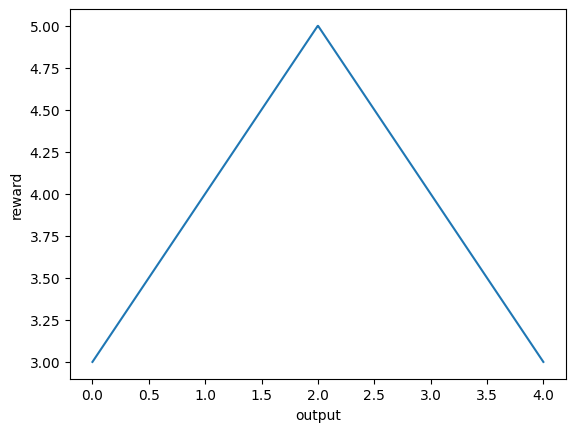

In [12]:
def plot_rewards() -> None:
    outputs = np.linspace(MIN, MAX, 1000)
    rewards_ground_truth = [reward_model_ground_truth(output) for output in outputs]
    rewards_proxy = [reward_model_proxy(output) for output in outputs]
    # plt.plot(outputs, rewards_proxy, alpha=1.0)
    plt.plot(outputs, rewards_ground_truth, alpha=1.0)
    plt.xlabel("output")
    plt.ylabel("reward")

# Plot the proxy and ground truth rewards
plot_rewards()

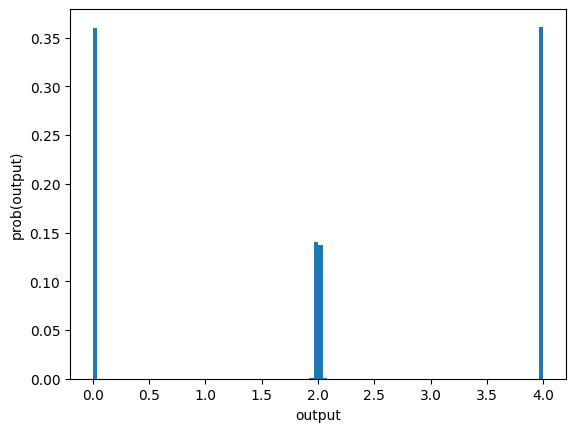

In [5]:
def best_of_n(n: int, reward_model):
    candidates = model(n)
    rewards = [reward_model(x) for x in candidates]
    idx = int(np.argmax(rewards))
    return candidates[idx], rewards[idx]


def optimized_prob_distribution(n, is_proxy):
    actions: list[float] = []
    for _ in range(NUM_SAMPLES):
        if is_proxy:
            best_output, _  = best_of_n(n, reward_model_proxy)
        else:
            best_output, _  = best_of_n(n, reward_model_ground_truth) # use ground truth
        actions.append(best_output)
    probs, bins = histogram(actions)
    return probs, bins

# Probabilities before best-of-n sampling
probs_initial: list[int] = BINS * [1/BINS]

# Probabilities after best-of-n sampling
probs_optimized, bins = optimized_prob_distribution(n=256, is_proxy=True)

def plot_optimized_output() -> None:
    plt.hist(bins[:-1], bins, weights=probs_optimized)
    plt.xlabel("output")
    plt.ylabel("prob(output)")

# Plot the output after best-of-n sampling using the proxy reward model
plot_optimized_output()

In [6]:
# The KL divergence for best-of-n sampling can be computed analytically, see page 31 https://arxiv.org/pdf/2009.01325.pdf
def kl_divergence_analytical(n):
    pass

def kl_divergence_numerical(p, q):
    p = np.asarray(p, dtype=float)
    q = np.asarray(q, dtype=float)
    mask = (p > 0) & (q > 0)
    return np.sum(p[mask] * np.log(p[mask] / q[mask]))

# The KL divergence between the initial distribution and the optimized distribution increases with n
for n in [2, 4, 8, 16, 32, 64, 128, 256]:
    # todo
    # print(f"n={n}, kl_divergence={}")
    probs_optimized, _ = optimized_prob_distribution(n, is_proxy=True)
    kl = kl_divergence_numerical(probs_optimized, probs_initial)
    print(f"n={n}, KL(optimized || initial) = {kl:.4f}")

n=2, KL(optimized || initial) = 0.1817
n=4, KL(optimized || initial) = 0.6127
n=8, KL(optimized || initial) = 1.1440
n=16, KL(optimized || initial) = 1.7353
n=32, KL(optimized || initial) = 2.2748
n=64, KL(optimized || initial) = 2.7434
n=128, KL(optimized || initial) = 3.0701
n=256, KL(optimized || initial) = 3.3124


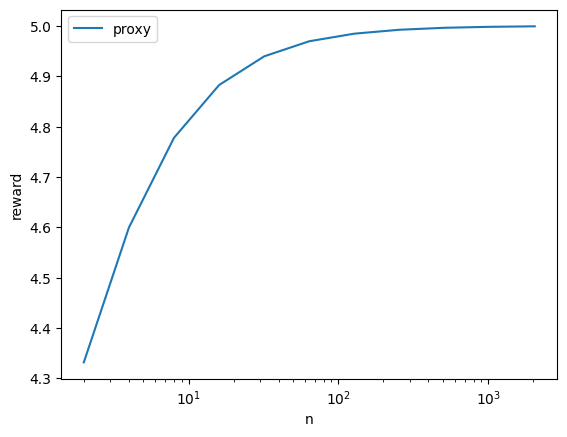

In [7]:
def estimate_reward(n:int, reward_model: Callable) -> float:
    # TODO
    total_reward = 0.0
    for _ in range(NUM_SAMPLES):
        _, best_reward = best_of_n(n, reward_model)
        total_reward += best_reward
    return total_reward / NUM_SAMPLES

rewards_ground_truth: list[float] = []

RANGE_N: list[int] = [2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048]
for n in RANGE_N:
    reward_ground_truth: float = estimate_reward(n, reward_model_ground_truth)
    rewards_ground_truth.append(reward_ground_truth)

# Plot proxy vs. ground truth rewards
# With uniform random noise, the proxy as well as the ground truth reward are monotonically increasing
# But thats not the case when using a real instead of a toy reward model, see https://arxiv.org/pdf/2210.10760.pdf
plt.plot(RANGE_N, rewards_ground_truth)
plt.xscale('log')
plt.ylabel('reward')
plt.xlabel('n')
plt.legend(['proxy', 'ground truth'])
plt.show()

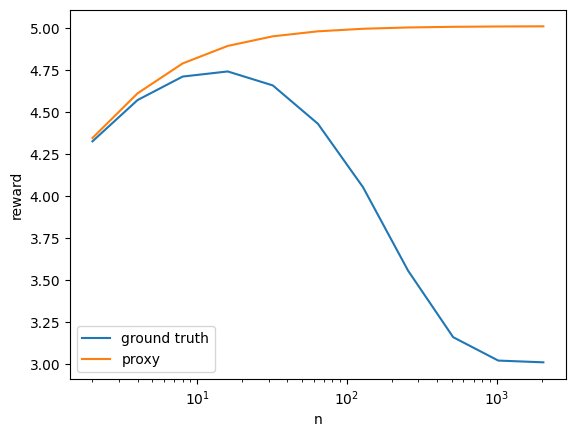

In [8]:
# why not using very large n?


def estimate_reward(n:int, reward_model: Callable) -> float:
    # TODO
    proxy_total = 0.0
    gt_total = 0.0
    for _ in range(NUM_SAMPLES):
        best_output, _ = best_of_n(n, reward_model)
        proxy_total += reward_model_proxy(best_output)
        gt_total += reward_model_ground_truth(best_output)
    return proxy_total / NUM_SAMPLES, gt_total / NUM_SAMPLES

rewards_ground_truth: list[float] = []
rewards_proxy: list[float] = []

RANGE_N: list[int] = [2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048]
for n in RANGE_N:
    reward_proxy, reward_ground_truth = estimate_reward(n, reward_model_proxy)
    rewards_proxy.append(reward_proxy)
    rewards_ground_truth.append(reward_ground_truth)

# Plot proxy vs. ground truth rewards
# With uniform random noise, the proxy as well as the ground truth reward are monotonically increasing
# But thats not the case when using a real instead of a toy reward model, see https://arxiv.org/pdf/2210.10760.pdf
plt.plot(RANGE_N, rewards_ground_truth)
plt.plot(RANGE_N, rewards_proxy)
plt.xscale('log')
plt.ylabel('reward')
plt.xlabel('n')
plt.legend(['ground truth', 'proxy'])
plt.show()